# Projekt 3 - Eksperymenty i analiza danych
## Autorzy
- Daniel Zdancewicz [145317]
- Alex Terentowicz [145419]

## Opis

Projekt polega na przeprowadzeniu eksperymentów z użyciem kilku metod i przeprowadzeniu analizy uzyskanych wyników.
Należało odnaleźć zbiór danych, który zawiera kilka kryteriów monotonicznych, ponad 100 alternatyw i co najmniej 2 klasy (jeśli problem ma więcej klas, możesz je zbinaryzować).

Krótko opisz zbiór danych, w tym opisy kryteriów. Dla tego zbioru danych wytrenuj następujące modele:
- Jeden prosty, interpretowalny model ML (np. XGBoost, rankSVM lub regresja logistyczna)
- Jeden interpretowalny model ANN-MCDA przedstawiony na zajęciach (ANN-Ch-Constr. lub ANN-UTADIS)
- Złożony model sici neuronowej zawierającej kilka warstw ukrytych.


## Opis zbioru danych

W tej pracy wybrany zbiór zawierający dane o udzielonych kredytach. Zbiór zawiera 614 rekordów, 13 kolumn i 2 klasy. Kolumny to:
- Loan_ID — Identyfikator udzielonego kredytu
- Gender — Płeć kredytobiorcy
- Married — Stan cywilny kredytobiorcy
- Dependents — Liczba osób na utrzymaniu kredytobiorcy
- Education — Wykształcenie kredytobiorcy
- Self_Employed — Czy kredytobiorca jest samozatrudniony
- ApplicantIncome — Miesięczny dochód kredytobiorcy
- CoapplicantIncome — Miesięczny dochód współkredytobiorcy
- LoanAmount — Kwota kredytu
- Loan_Amount_Term — Okres spłaty kredytu w miesiącach
- Credit_History — Historia kredytowa kredytobiorcy
- Property_Area — Lokalizacja nieruchomości kredytobiorcy
- Loan_Status — Czy kredyt został spłacony

Źródło danych — [Kaggle](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset)

Jako kryteria monotoniczne wybrano:
- ApplicantIncome
- CoapplicantIncome
- LoanAmount
- Loan_Amount_Term

Jako kryteria niemonotoniczne wybrano:
- Gender
- Married
- Dependents
- Education
- Self_Employed
- Credit_History
- Property_Area

Jako klasy wybrano kolumnę Loan_Status, która zawiera informacje o tym czy kredyt został spłacony:
- Y — Kredyt został spłacony
- N — Kredyt nie został spłacony



## Preprocessing

Dane zostały wczytane z pliku csv przy użyciu biblioteki pandas, wiersze z niespójnościami zostały pominięte. Po czym dokonano na danych zmian polegających na usunięciu kolumny Loan_ID oraz zamianie wartości kolumny Loan_Status na wartości liczbowe:
- Y — 1
- N — 0

Dodatkowo pozostałe kolumny zostały zamienione na wartości liczbowe przy użyciu kodowania liczbowego, aby z łatwością mogły być przetwarzane przez modele ML.

df["Gender"].map({"Male": 1, "Female": 0})
df["Married"].map({"Yes": 1, "No": 0})
df["Dependents"].map({"0": 0, "1": 1, "2": 2, "3+": 3})
df["Education"].map({"Graduate": 1, "Not Graduate": 0})
df["Self_Employed"].map({"Yes": 1, "No": 0})
df["Property_Area"].map({"Urban": 2, "Semiurban": 1, "Rural": 0})


## Naprawa importów

In [77]:
import os
import sys

import torch
module_path = os.path.abspath('src')
if module_path not in sys.path: sys.path.append(module_path)

In [23]:
from src.mod.models.manager import ModelManager
from src.mod.dataset import LoanDataset

dataset = LoanDataset.load()
manager = ModelManager

In [24]:
dataset.labeled.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Trening modeli

### LogisticRegression — interpretowalny model ML

In [47]:
logistic = ModelManager.use_logistic(dataset, invalidate=True)
print(logistic)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
LogisticModel(regressor=LogisticRegression(), validator=GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1, param_grid={},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc'},
             verbose=1))


In [75]:
print(f"Trafność regresji logistycznej ML: {logistic.validator.best_score_ * 100:.2f}%")

Trafność regresji logistycznej ML: 80.83%


### Eksperymenty i przedstawienie wyników regresji logistycznej

Macierz pomyłek:

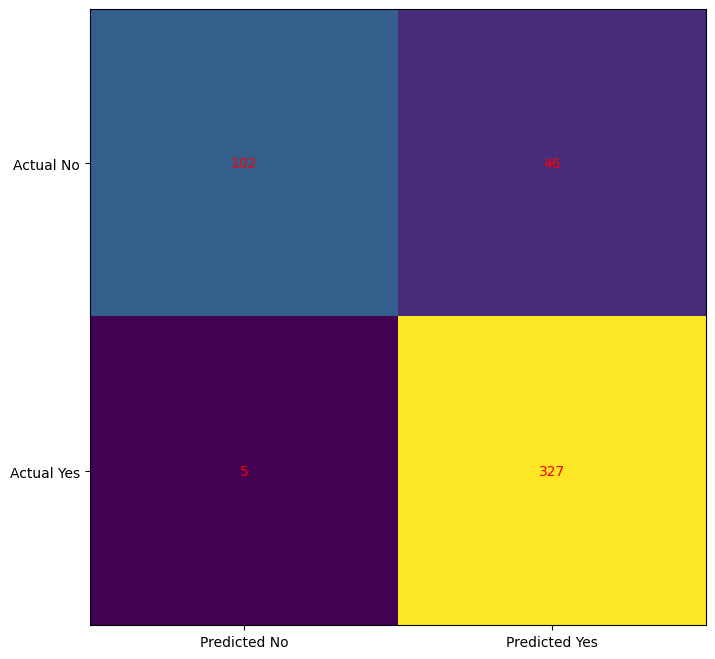

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix():
  X, y_true, _ = dataset.preprocess(variant='labeled')
  X = logistic._encoder.fit_transform(X)

  y_pred = logistic.validator.predict(X)
  cm = confusion_matrix(y_true, y_pred)

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted No', 'Predicted Yes'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual No', 'Actual Yes'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
    for j in range(2):
      ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  plt.show()

plot_confusion_matrix()

In [60]:
from sklearn.metrics import classification_report

def print_classification_report():
  X, y_true, _ = dataset.preprocess(variant='labeled')
  X = logistic._encoder.fit_transform(X)

  y_pred = logistic.validator.predict(X)
  print(classification_report(y_true, y_pred))

print_classification_report()

              precision    recall  f1-score   support

           0       0.95      0.69      0.80       148
           1       0.88      0.98      0.93       332

    accuracy                           0.89       480
   macro avg       0.91      0.84      0.86       480
weighted avg       0.90      0.89      0.89       480



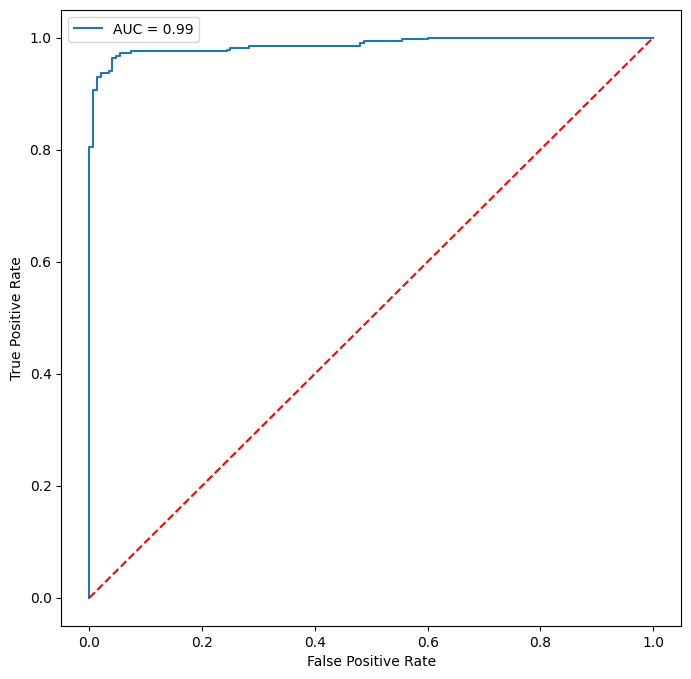

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve():
  X, y_true, _ = dataset.preprocess(variant='labeled')
  X = logistic._encoder.fit_transform(X)

  y_pred = logistic.validator.predict_proba(X)[:, 1]
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  auc = roc_auc_score(y_true, y_pred)

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
  ax.plot([0, 1], [0, 1], color='red', linestyle='--')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.legend()
  plt.show()

plot_roc_curve()

### ANN-Ch-Constr. — interpretowalny model ANN-MCDA

Model składa się z 3 warstw:

AnnModel(model=ChoquetConstrained(
  (criteria_layer): LinearGreaterThanZero(in_features=4, out_features=1, bias=False)
  (interaction_layer): LinearInteraction(
    in_features=4, out_features=1, bias=False
    (criterion_layer): LinearGreaterThanZero(in_features=4, out_features=1, bias=False)
  )
  (thresholdLayer): ThresholdLayer()
))

In [127]:
import numpy as np
ann = manager.use_ann(dataset)
ann_memory = torch.load(manager._ann_path)

def print_weights():
  model = ann.model
  weights = model.criteria_layer.w().detach().numpy()[0]
  interaction_weights = model.interaction_layer.w().detach().numpy()[0]
  s = weights.sum() + interaction_weights.sum()
  weights = weights / s
  interaction_weights = interaction_weights / s

  criteria_nr = 4
  interactions = np.zeros((criteria_nr, criteria_nr))
  weight_id = 0
  for i in range(criteria_nr):
    for j in range(i + 1, criteria_nr):
      interactions[i, j] = interactions[j, i] = interaction_weights[weight_id]
      weight_id += 1

  print("Wagi kryteriów:")
  print([round(weight, 2) for weight in weights])

  print()
  print("Interakcje między kryteriami:")
  print(*[[round(weight, 2) for weight in interaction] for interaction in interactions], sep='\n')

print(f"Nauka : Trafność : {ann_memory['train']['accuracy'] * 100:.2f}%")
print(f"Nauka : AUC      : {ann_memory['train']['auc'] * 100:.2f}%")
print(f"Test  : Trafność : {ann_memory['test']['accuracy'] * 100:.2f}%")
print(f"Test  : AUC      : {ann_memory['test']['auc'] * 100:.2f}%")
print()
print_weights()


Nauka : Trafność : 56.25%
Nauka : AUC      : 52.38%
Test  : Trafność : 75.00%
Test  : AUC      : 79.17%

Wagi kryteriów:
[0.29, 0.14, 0.09, 0.35]

Interakcje między kryteriami:
[0.0, 0.08, -0.02, -0.03]
[0.08, 0.0, -0.01, 0.07]
[-0.02, -0.01, 0.0, 0.03]
[-0.03, 0.07, 0.03, 0.0]


### Głęboka sieć neuronowa — model złożony.

Jako model złożony została użyta głęboka sieć neuronowa o architekturze:

DnnModel(model=Sequential(
  (0): Linear(in_features=11, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.1, inplace=False)
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Linear(in_features=128, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
  (19): Sigmoid()
))


In [78]:
dnn = manager.use_dnn(dataset)
dnn_memory = torch.load(manager._dnn_path)

In [126]:
print(f"Nauka : Trafność : {dnn_memory['train']['accuracy'] * 100:.2f}%")
print(f"Nauka : AUC      : {dnn_memory['train']['auc'] * 100:.2f}%")
print(f"Test  : Trafność : {dnn_memory['test']['accuracy'] * 100:.2f}%")
print(f"Test  : AUC      : {dnn_memory['test']['auc'] * 100:.2f}%")
print()


Nauka : Trafność : 56.25%
Nauka : AUC      : 73.02%
Test  : Trafność : 75.00%
Test  : AUC      : 43.75%



### Interpretacja - Permutation Feature Importance

In [169]:
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation
from captum.attr import FeaturePermutation
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import matplotlib.pyplot as plt

perm = FeaturePermutation(dnn.model)

(X, y, _) = dataset.preprocess(variant="labeled")
X_train, X_test, y_train, y_test = map(lambda x: torch.tensor(x, dtype=torch.float),
                                       train_test_split(X, y, test_size=0.1, random_state=10))

model = dnn.model
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
gs = GradientShap(model)
fa = FeatureAblation(model)

ig_attr_test = ig.attribute(X_test, n_steps=50)
ig_nt_attr_test = ig_nt.attribute(X_test)
dl_attr_test = dl.attribute(X_test)
gs_attr_test = gs.attribute(X_test, X_train)
fa_attr_test = fa.attribute(X_test)

/home/alex/Repos/ISWD/2023-iswd/project-3-preferential/venv/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/alex/Repos/ISWD/2023-iswd/project-3-preferential/venv/lib/python3.10/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


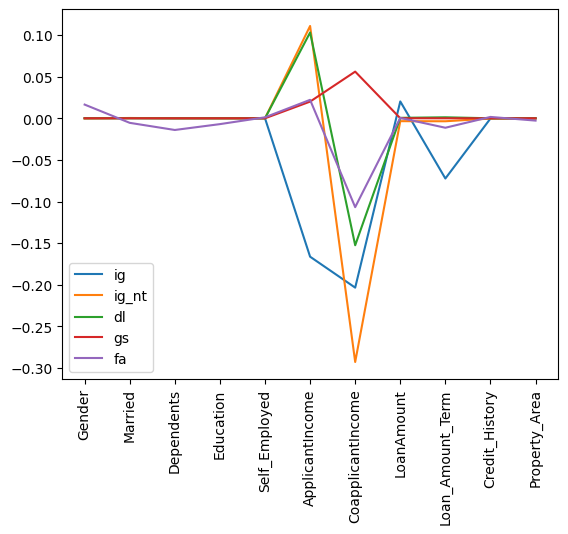

In [172]:
plt.plot(ig_attr_test[0].detach().numpy(), label="ig")
plt.plot(ig_nt_attr_test[0].detach().numpy(), label="ig_nt")
plt.plot(dl_attr_test[0].detach().numpy(), label="dl")
plt.plot(gs_attr_test[0].detach().numpy(), label="gs")
plt.plot(fa_attr_test[0].detach().numpy(), label="fa")

cols = dataset.labeled.columns.tolist()
for x in ["Loan_ID", "Loan_Status"]: cols.remove(x)
plt.xticks(range(len(cols)), cols, rotation=90)
plt.legend()
plt.show()

### Wyniki eksperymentów

Wyniki eksperymentów wykazały, że głębokie sieci neuronowe (DNNs) i sztuczne sieci neuronowe (ANNs) nie zawsze są lepsze od klasycznych metod regresji. Chociaż DNN i ANN są potężnymi modelami obliczeniowymi, eksperymenty pokazują, że nie stanowią rozwiązania dla wszystkich problemów. Klasyczne metody regresji, ze względu na swoją prostotę i interpretowalność, okazały się zdolne do dostarczania lepszych wyników niż DNN i ANN. Interpretowalność tych klasycznych metod jest kluczowa dla zrozumienia i tworzenia kolejnych metod wraz z wykorzystaniem wiedzy dziedzinowej. To potencjalnie przynosi lepsze wyniki niż automatyczne zastosowanie najnowszych technik. Odkrycia